In [1]:
import networkx as nx
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nltk
import community.community_louvain as community
import squarify
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.patches as mpatches
nltk.download("stopwords")
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clairmutebi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
with open("LargeData/Directed2022.pkl", "rb") as file:
    G = pickle.load(file)

# Make GCC
UnG = G.to_undirected()
G = nx.subgraph(G, [node for node in G.nodes()][:1000])
G = nx.subgraph(G,max(nx.weakly_connected_components(G), key=len)) # GCC

In [3]:
G = G.to_undirected()

# Get node attributes for authors and their flair
authors = list(G.nodes())
flairs = nx.get_node_attributes(G, 'flair')

# Dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()), columns=['Author', 'Flair'])

trials = 100
number_of_communities = np.zeros(trials)
for i in range(trials):
    if i % 100 == 0:
        print(i)
    partition = community.best_partition(G)
    number_of_communities[i] = len(set(partition.values()))

med = int(np.median(number_of_communities))
# Print the number of communities
print("Mean number of communities:", np.mean(number_of_communities))
print("Median number of communities:", int(np.median(number_of_communities)))

0
Mean number of communities: 6.89
Median number of communities: 7


In [4]:
def modularity(G,partition):
    modularity_vals = []
    L = G.number_of_edges()
    for i in range(len(partition)):
        Lc = G.subgraph(partition[i]).number_of_edges()
        kc = 0
        for node in partition[i]:
            kc += G.degree(node)
        modularity_vals.append(Lc/L - (kc/(2*L))**2)
    return sum(modularity_vals)

while True:
    partition = community.best_partition(G)
    if len(set(partition.values())) == med:
        break

In [5]:
# Create dataframe with author and community
df_community = pd.DataFrame(list(partition.items()),columns = ['Author','Community'])
df_community = df_community.sort_values(by='Community')

# Merge the community information with flair information based on authors
merged_df = pd.merge(df_community, df_flairs, on='Author')

# Overall flair distribution across all communities
flair_counts = merged_df.groupby('Flair')['Author'].nunique()

In [6]:
# Save df_community as pkl
with open('LargeData/df_community.pickle', 'wb') as f:
    pickle.dump(df_community, f)

In [7]:
# modularity
print('Modularity of best partition:',modularity(G, [df_community[df_community['Community']==i]['Author'].values for i in range(len(df_community['Community'].unique()))]))

Modularity of best partition: 0.18677488600986278


In [8]:
specific_community = 1
community_data = merged_df[merged_df['Community'] == specific_community]
community_flair_counts = community_data['Flair'].value_counts()

print("Top flair in community 1: ")
print(community_flair_counts[:3])

Top flair in community 1: 
Flair
intp    50
infp    35
infj    34
Name: count, dtype: int64


Communities plot

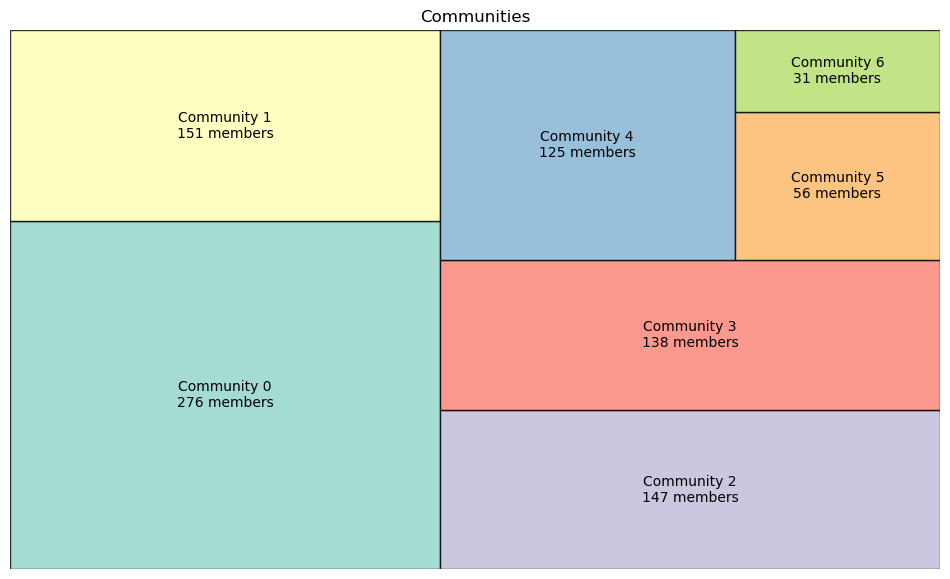

In [10]:
number_of_unique_communities = len(df_community['Community'].unique())
number_of_members_in_each_community = df_community['Community'].value_counts().values

labels = ['Community ' + str(i) + '\n' + str(number_of_members_in_each_community[i]) + ' members' for i in range(number_of_unique_communities)]
plt.figure(figsize=(12,7))
squarify.plot(sizes=df_community['Community'].value_counts().values,label=labels,alpha=.8,color=sb.color_palette("Set3", number_of_unique_communities),ec='black')
plt.title('Communities')
plt.axis('off')
plt.show()

Graph over communities and the flairs active in those communities compared to the overall distributions of the flairs in the MBTI forum

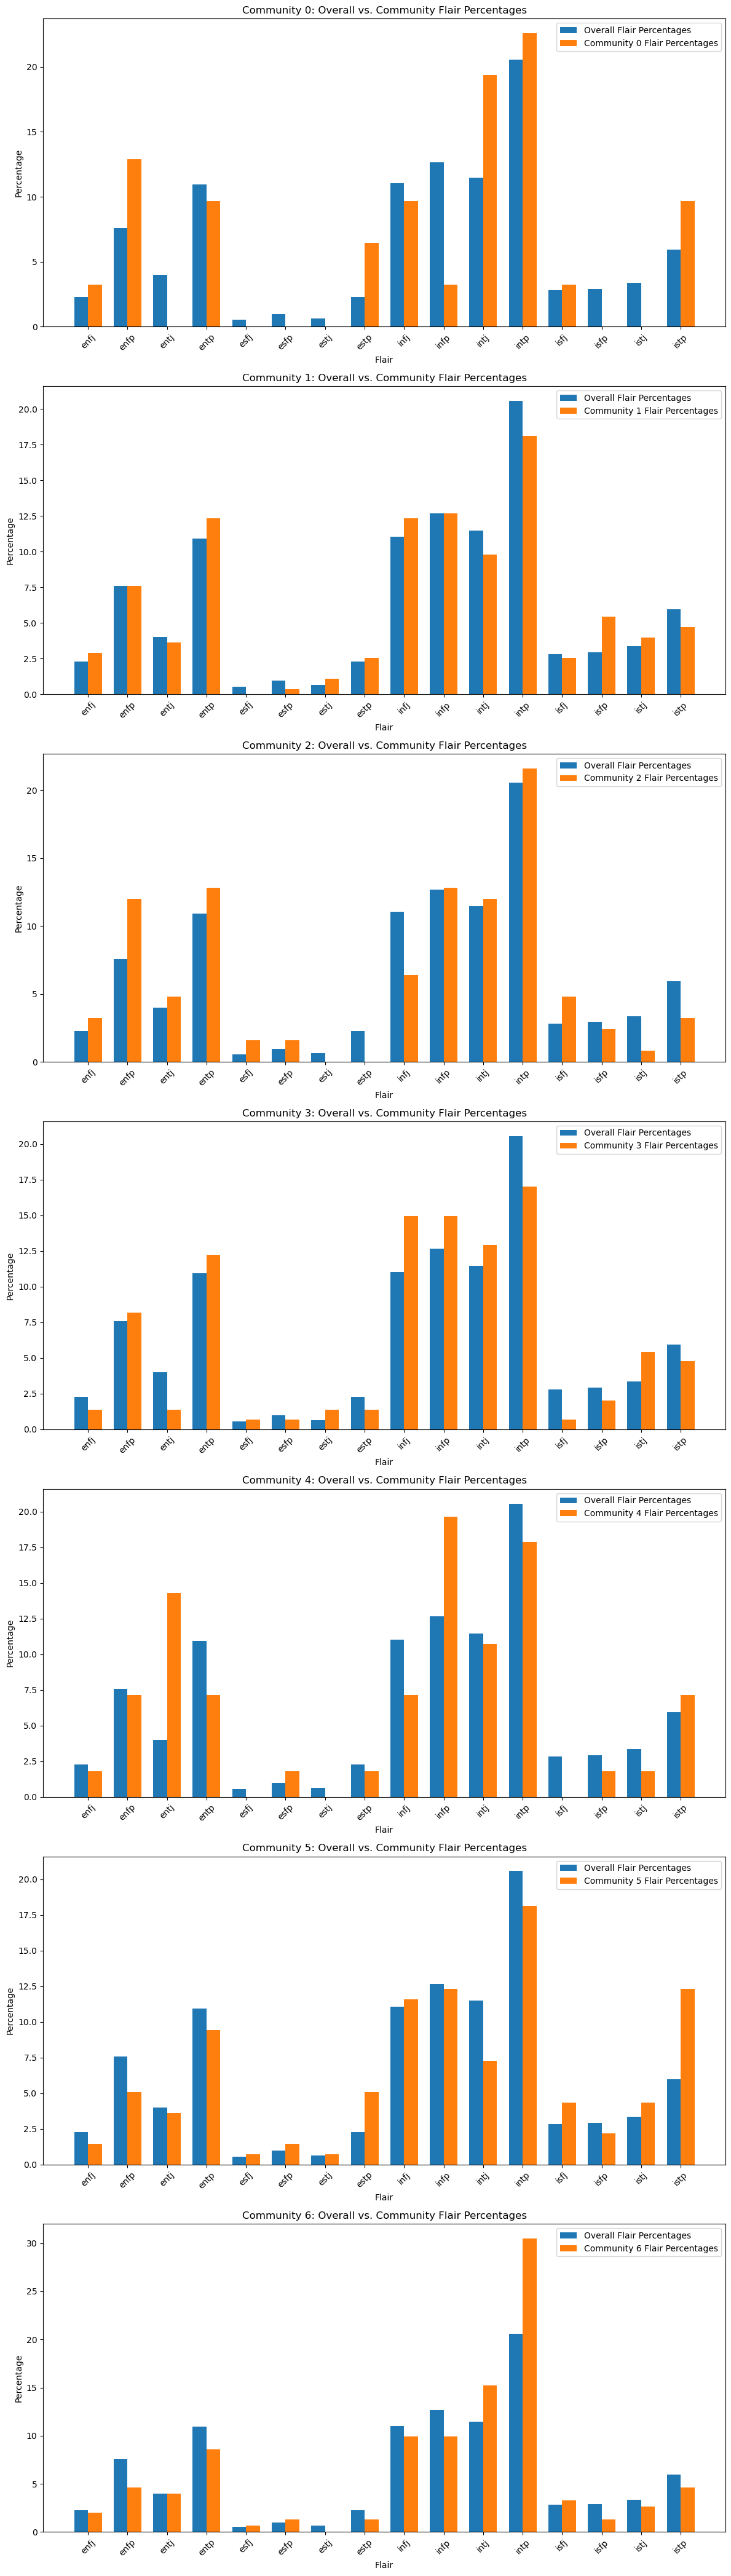

In [13]:
# Getting unique communities
unique_communities = merged_df['Community'].unique()

# Setting up subplots to display plots for each community
num_communities = len(unique_communities)
fig, axes = plt.subplots(num_communities, 1, figsize=(12, 6 * num_communities))

for idx, specific_community in enumerate(unique_communities):
    
    # Overall flair counts across all communities
    flair_counts = merged_df.groupby('Flair')['Author'].nunique()

    # Flair counts within a specific community
    community_data = merged_df[merged_df['Community'] == specific_community]
    community_flair_counts = community_data['Flair'].value_counts()

    # Calculate percentages
    total_flair_counts = flair_counts.sum()
    community_percentages = (community_flair_counts / community_flair_counts.sum()) * 100

    # Bar plot for overall flair counts and community flair counts side by side
    bar_width = 0.35
    index = np.arange(len(flair_counts))

    ax = axes[idx]
    rects1 = ax.bar(index, (flair_counts / total_flair_counts) * 100, bar_width, label='Overall Flair Percentages')
    rects2 = ax.bar(index + bar_width, community_percentages.reindex(flair_counts.index, fill_value=0).values,
                    bar_width, label=f'Community {specific_community} Flair Percentages')

    ax.set_xlabel('Flair')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Community {specific_community}: Overall vs. Community Flair Percentages')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(flair_counts.index, rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# find the authors from the graph in data
authors = list(G.nodes())
flairs = nx.get_node_attributes(G,'flair')

# Make dataframe with authors and flairs
df_flairs = pd.DataFrame(list(flairs.items()),columns = ['Author','Flair'])

# Compute modularity for the authors divided into flairs
modularity_flairs = modularity(G, [df_flairs[df_flairs['Flair']==i]['Author'].values for i in df_flairs['Flair'].unique()])
print('Modularity Flairs:',modularity_flairs)

Modularity Flairs: 0.05613803884108743
